Greetings!

This notebook contains a demo for using a research prototype implementation of two deletion efficient k-means algorithms, Q-k-means and DC-k-means.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from del_eff_kmeans import Kmeans, QKmeans, DCKmeans
import time

First, let's generate a simple dataset based on a Gaussian mixture. Let's assume we have three clusters.

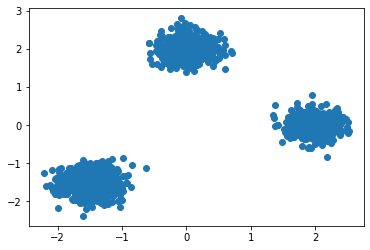

In [2]:
k = 3
n1 = 5*10**2
n2 = 5*10**2
n3 = 8*10**2
n = n1 + n2 + n3
cov = [[0.05,0],[0,0.05]]
def sample_gmm():
    cluster1 = np.random.multivariate_normal([2,0], cov , n1)
    cluster2 = np.random.multivariate_normal([0,2], cov , n2)
    cluster3 = np.random.multivariate_normal([-1.5,-1.5], cov , n3)
    return np.vstack((cluster1,cluster2,cluster3))

data = sample_gmm()
plt.scatter(data[:,0],data[:,1])
plt.show()

I bet you can guess where each center will end up!

Let's run the algorithms. First up is classic k-means++!

In [3]:
def show_clustering(centers,assignments,data):
    colors = ['r','b','g']
    for a in [0,1,2]:
        data_a = data[assignments == a]
        plt.scatter(data_a[:,0],data_a[:,1])
        plt.scatter(centers[a,0],centers[a,1],marker='x',color='k')
    plt.show()

Clustering loss is 0.10016343916399469


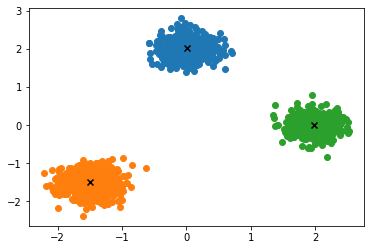

In [4]:
kmeans = Kmeans(k)
centers, assignments, loss = kmeans.run(data.copy())
print(f'Clustering loss is {loss}')
show_clustering(centers, assignments, data)

Did you get what you expected? Remember that k-means isn't guaranteed to converge to a global minimum! You might want to run the above cell again if you think the algorithm got stuck in a bad local minimum.

Next up is Q-k-means! Let's set the quantization fidelty parameter to 0.05.

Clustering loss is 0.10050008336582114


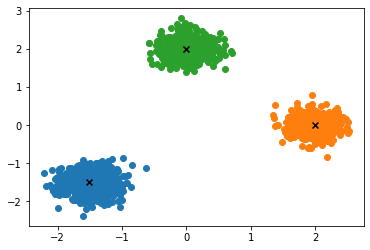

In [5]:
#second parameter in function call is quantization epsilon
qkmeans = QKmeans(k,0.05)
centers, assignments, loss = qkmeans.run(data.copy())
print(f'Clustering loss is {loss}')
show_clustering(centers, assignments, data)

Finally we've got DC-k-means. Let's split up the data into 16 buckets.

Clustering loss is 0.10200375157582053


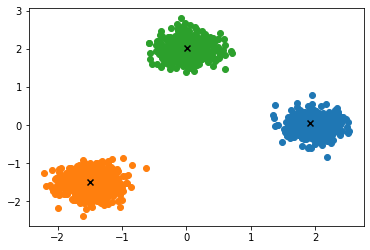

In [6]:
#first parameter is a list of k's for sub-problems at each layer
#second parameter is the number of buckets for each layer
dckmeans = DCKmeans([k,k],[1,16])
centers, assignments, loss = dckmeans.run(data.copy(),assignments=True)
print(f'Clustering loss is {loss}')
show_clustering(centers, assignments, data)

These three methods should be produce fairly similar clusters (unless one happened to get stuck in a bad local minimum).

Now we can see how quickly the methods can process a sequence of 20 deletion requests!

In [7]:
def online_deletion_stream(num_dels,model):
    t0 = time.time()
    c = 1
    for _ in range(num_dels):
        dr = np.random.choice(model.n,size=1)[0]
        print(f'processing deletion request # {c}...')
        model.delete(dr)
        c += 1
    t = time.time()
    print(f'Total time to process {c-1} deletions is {t-t0}')

For the k-means baseline, each we have to satisfy each "deletion" by re-training from scratch.

In [8]:
print('Simulation deletion stream for kmeans')
online_deletion_stream(20,kmeans)

Simulation deletion stream for kmeans
processing deletion request # 1...
processing deletion request # 2...
processing deletion request # 3...
processing deletion request # 4...
processing deletion request # 5...
processing deletion request # 6...
processing deletion request # 7...
processing deletion request # 8...
processing deletion request # 9...
processing deletion request # 10...
processing deletion request # 11...
processing deletion request # 12...
processing deletion request # 13...
processing deletion request # 14...
processing deletion request # 15...
processing deletion request # 16...
processing deletion request # 17...
processing deletion request # 18...
processing deletion request # 19...
processing deletion request # 20...
Total time to process 20 deletions is 9.042957067489624


Let's see if we can get any speed-up from Q-k-means or DC-k-means using specialized deletion operations.

In [9]:
print('Simulation deletion stream for qkmeans')
online_deletion_stream(20,qkmeans)

Simulation deletion stream for qkmeans
processing deletion request # 1...
processing deletion request # 2...
processing deletion request # 3...
processing deletion request # 4...
processing deletion request # 5...
processing deletion request # 6...
processing deletion request # 7...
processing deletion request # 8...
processing deletion request # 9...
processing deletion request # 10...
processing deletion request # 11...
processing deletion request # 12...
processing deletion request # 13...
processing deletion request # 14...
processing deletion request # 15...
processing deletion request # 16...
processing deletion request # 17...
processing deletion request # 18...
processing deletion request # 19...
processing deletion request # 20...
Total time to process 20 deletions is 0.003999948501586914


In [10]:
print('Simulation deletion stream for dckmeans')
online_deletion_stream(20,dckmeans)

Simulation deletion stream for dckmeans
processing deletion request # 1...
processing deletion request # 2...
processing deletion request # 3...
processing deletion request # 4...
processing deletion request # 5...
processing deletion request # 6...
processing deletion request # 7...
processing deletion request # 8...
processing deletion request # 9...
processing deletion request # 10...
processing deletion request # 11...
processing deletion request # 12...
processing deletion request # 13...
processing deletion request # 14...
processing deletion request # 15...
processing deletion request # 16...
processing deletion request # 17...
processing deletion request # 18...
processing deletion request # 19...
processing deletion request # 20...
Total time to process 20 deletions is 0.8742086887359619


So it seems like both methods are a good deal faster! That's a win for deletion efficient clustering techniques.

For this demo dataset, you are likely to see that Q-k-means outperforms DC-k-means in terms of deletion time. That's because `n` (the number of points in datatset) is much larger than `k` (the number of clusters) or `d` (dimension of the points). When this isn't true, you are may observe that DC-k-means is as fast or even faster than Q-k-means.

Also, keep in mind that Q-k-means usually has larger variability around its expected deletion time than DC-k-means. 

Please refer to the full paper for more details about these methods and other deletion efficient algorithms.